# ORF recognition by CNN

In 105, we used Conv1D layers with filter width=3 with dropout to reduce overfitting. The simulated RNA lengths were 1000.

As validation of the 107 notebook, use pc_sim to generate both sets, but introduce a SNP rather than indel to the pcRNA. Like 108, this result validates 107.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-10 20:25:21 UTC'

In [2]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=21            # how long is each sequence
CDS_LEN=15
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=20  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    tora = Transcript_Oracle()
    tora.set_cds_len_mean(CDS_LEN)  # CDS=ORF+STOP. Method is misnamed.
    pcgen.set_seq_oracle(tora)
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_SEQUENCES+PC_TESTS)
nc_all = pc_sim.get_sequences(NC_SEQUENCES+NC_TESTS) # YES, use PC for both!
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

Use 3000 PC seqs
Use 3000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 21.0
Average ORF length: 11.041
NC seqs
Average RNA length: 21.0
Average ORF length: 11.037


In [7]:
import random
def alter_sequences(list_of_seq,center):
    global next_pos,bases
    new_list = []
    for S in list_of_seq:
        seq_len = len(S)
        next_left = random.choice([True,False])
        next_base = random.choice(['A','C','G','T'])
        new_seq=""
        if center:
            half=seq_len//2
            if next_left:
                new_seq=S[0:half]+next_base+S[half+1:]
            else:
                new_seq=S[0:half-1]+next_base+S[half:]
        else:
            if next_left:
                new_seq=next_base+S[1:]
            else:
                new_seq=S[:-1]+next_base 
        new_list.append(new_seq)
    return new_list
pc_all = alter_sequences(pc_all,False)
nc_all = alter_sequences(nc_all,True)

print("Simulated sequences after adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences after adjustment:
PC seqs
Average RNA length: 21.0
Average ORF length: 10.858
NC seqs
Average RNA length: 21.0
Average ORF length: 10.894


In [8]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [9]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [10]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (21, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 21, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 16)            784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)         

In [11]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 29s 9ms/step - loss: 0.7132 - accuracy: 0.4919 - val_loss: 0.6972 - val_accuracy: 0.4837
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7073 - accuracy: 0.4927 - val_loss: 0.6942 - val_accuracy: 0.5050
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5205 - val_loss: 0.6943 - val_accuracy: 0.4925
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5350 - val_loss: 0.6936 - val_accuracy: 0.5138
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5405 - val_loss: 0.6949 - val_accuracy: 0.5038
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 

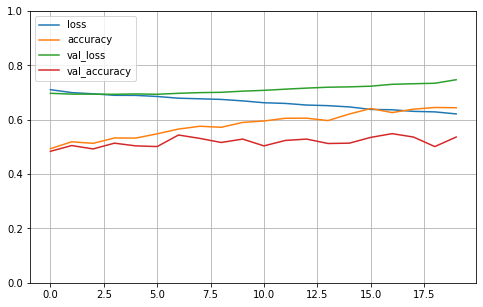

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 2s 7ms/step - loss: 0.7348 - accuracy: 0.4954 - val_loss: 0.6937 - val_accuracy: 0.4975
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5179 - val_loss: 0.6937 - val_accuracy: 0.5050
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5095 - val_loss: 0.6941 - val_accuracy: 0.4900
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5321 - val_loss: 0.7001 - val_accuracy: 0.4725
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5416 - val_loss: 0.6953 - val_accuracy: 0.5038
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5435 - val_loss: 0.7007 - val_accuracy: 0.4837
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5520 - val_lo

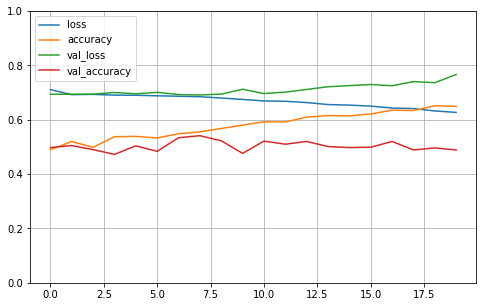

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 2s 7ms/step - loss: 0.7217 - accuracy: 0.5235 - val_loss: 0.6961 - val_accuracy: 0.4863
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7051 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5038
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5200 - val_loss: 0.6934 - val_accuracy: 0.5050
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5358 - val_loss: 0.6942 - val_accuracy: 0.5113
Epoch 5/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5334 - val_loss: 0.6955 - val_accuracy: 0.5050
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5427 - val_loss: 0.6973 - val_accuracy: 0.5100
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5662 - val_lo

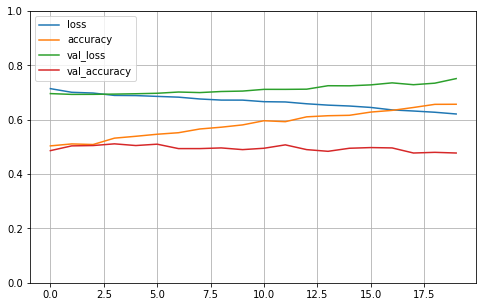

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 2s 7ms/step - loss: 0.7412 - accuracy: 0.5055 - val_loss: 0.6995 - val_accuracy: 0.5063
Epoch 2/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5058 - val_loss: 0.6933 - val_accuracy: 0.4812
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5286 - val_loss: 0.6930 - val_accuracy: 0.5188
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5215 - val_loss: 0.6934 - val_accuracy: 0.5175
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5503 - val_loss: 0.6938 - val_accuracy: 0.5038
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6948 - val_accuracy: 0.4975
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5277 - val_lo

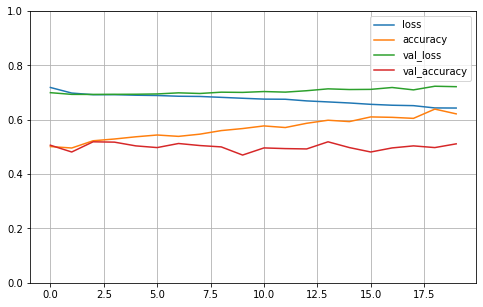

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 2s 7ms/step - loss: 0.7302 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5150
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.5134 - val_loss: 0.6943 - val_accuracy: 0.5238
Epoch 3/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5354 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5219 - val_loss: 0.6936 - val_accuracy: 0.5050
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5277 - val_loss: 0.7023 - val_accuracy: 0.4775
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5318 - val_loss: 0.6977 - val_accuracy: 0.4975
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5582 - val_lo

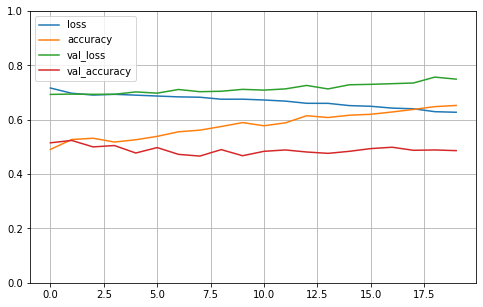

In [12]:
do_cross_validation(X,y)

In [13]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 49.90%


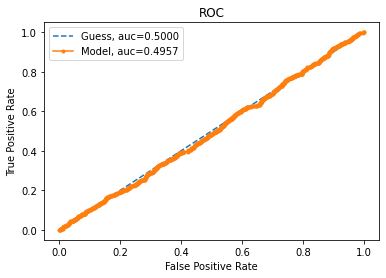

AUC: 49.57%


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [15]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-10 20:26:56 UTC'

## Conclusion
Experiment 107 is validated again.